In [ ]:
!wget --no-check-certificate -nc https://github.com/Galina-Blokh/ai_assignment_aidock/blob/distilbert_impl/data/new_recipe.pkl?raw=true -O new_recipe.pkl

!pip install transformers

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
import transformers

from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification

pd.set_option('display.max_colwidth', None)

warnings.filterwarnings('ignore')

MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'# This model is a fine-tune checkpoint of DistilBERT-base-uncased, fine-tuned on SST-2.
BATCH_SIZE = 16
N_EPOCHS = 10

In [4]:
df = pd.DataFrame(pd.read_pickle('new_recipe.pkl'))
df[700:702]

,Recipe,INSTRUCTIONS
700,"[1 cup uncooked brown rice, well rinsed, 2 cups water, 1 teaspoon extra-virgin olive oil]","Combine the rinsed rice, water, and olive oil in a pot and bring to a boil. Cover, reduce the heat to low, and simmer for 45 minutes.\n\nRemove from the heat and let it sit, covered for 10 more minutes. Fluff with a fork."
701,"[Butternut squash, Beet, Cucumber, Carrot, Daikon radish, Summer squash, Kohlrabi, Sweet potato, Zucchini]","Butternut squash noodles: Look for a squash with a long neck. Chop off the fat, seedy base of the squash and save it for another use (see suggestions in the post above). Peel the squash and use a spiralizer to make noodles.\n\nBeet noodles: Look for a large beet. Peel off the skin and use a spiralizer to make noodles.\n\nCucumber noodles: Look for a large English cucumber. Use a spiralizer or julienne peeler to make noodles (no need to peel).\n\nCarrot noodles: Look for a fat carrot. Scrub well or peel if it’s too dirty. Use a spiralizer or julienne peeler to make noodles.\n\nDaikon noodles: Use a spiralizer to make noodles.\n\nSummer squash noodles: Look for a large yellow squash. Use a spiralizer or julienne peeler to make noodles. Or use a regular vegetable peeler and peel into thick ribbon-shaped noodles. There’s no need to peel the skin of the squash.\n\nKohlrabi noodles: Chop the greens off and save for another use. Peel off any nubby parts from the kohlrabi bulb. Use a spiralizer to make noodles.\n\nSweet potato noodles: Look for a thick sweet potato. Peel the sweet potato and use a spiralizer to make noodles.\n\nZucchini noodles: Look for a large zucchini. Use a spiralizer or julienne peeler to make noodles. Or use a regular vegetable peeler and peel into thick ribbon-shaped noodles. There’s no need to peel the skin of the zucchini."


In [5]:
def create_dataset(df):
  recipe_col = df["Recipe"].apply(lambda series: ' '.join([words for words in series])).to_numpy()

  recipe = recipe_col.reshape(-1, 1)
  recipe = np.hstack((recipe, np.ones(len(recipe), int).reshape(-1, 1)))

  instr_col = df["INSTRUCTIONS"].str.split('\n\n').to_numpy()

  instr = np.concatenate(instr_col).reshape(-1, 1)
  instr = np.hstack((instr, np.zeros(len(instr), int).reshape(-1, 1)))

  # concatinate two ndArrays into one
  data = np.concatenate((instr, recipe), axis=0)
  print('The concatenated set  shape: ',data.shape)

  # remove duplicates
  unique = np.unique(data.astype(str), axis=0)
  print("The set without duplicates  shape: ",unique.shape)

  # #remove empty string rows(from table)
  unique = np.delete(unique.astype(str), np.where(unique == ''), axis=0)
  print("The set without empty rows  shape: ",unique.shape)

  data =  pd.DataFrame(unique, columns=['paragraph', 'label'])
  return data

data = create_dataset(df)
data.tail(2)

The concatenated set  shape:  (5190, 2)
The set without duplicates  shape:  (4919, 2)
The set without empty rows  shape:  (4917, 2)


,paragraph,label
4915,⅔ cup good quality coffee beans (or buy them pre-ground). 3 cups filtered water Almond Breeze Almondmilk Original (about 1 cup per latte),1
4916,"⅔ cup sliced leeks (the tender white and light green parts only) Extra-virgin olive oil, for drizzling 1 garlic clove, chopped 2 small zucchini, chopped + a few strands of spiralized or julienned zucchini for garnish ¼ cup hemp seeds juice of ½ lemon, more to taste ½ tablespoon miso paste 1 cup water, more as needed for consistency ½ cup packed fresh basil sea salt and freshly ground black pepper 2 cups cubed sourdough bread ½ garlic clove, minced Extra-virgin olive oil, for drizzling",1


The proportion in y_train
 0    79.532164
1    20.467836
Name: label, dtype: float64
The proportion in y_test
 0    79.471545
1    20.528455
Name: label, dtype: float64
The proportion in data
 0    79.520033
1    20.479967
Name: label, dtype: float64


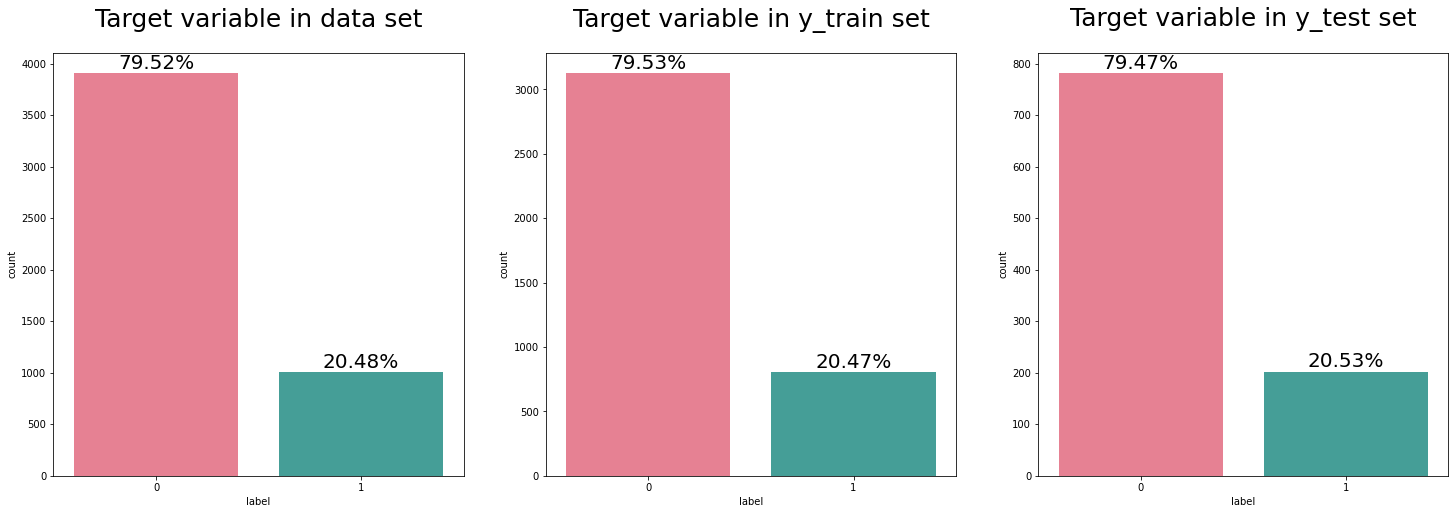

In [6]:
def split_and_plot_target(data):
  X = data['paragraph'].copy()
  y = data['label'].astype(int).copy()
  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      stratify=y, 
                                                      test_size=0.2, 
                                                      random_state=42)

  print('The proportion in y_train\n',y_train.value_counts(normalize=True).mul(100))
  print('The proportion in y_test\n',y_test.value_counts(normalize=True).mul(100))
  print('The proportion in data\n',data.label.value_counts(normalize=True).mul(100))


  plt.figure(figsize=(25,5))
  for vector, name,i in zip([data.label,y_train, y_test],['data','y_train', 'y_test'],np.arange(3)):
      plt.subplot(1,3,i+1)
      bar = sns.countplot(vector,palette='husl')
      plt.text(0.5, len(vector)*0.9,f"Target variable in {str(name)} set",
          horizontalalignment='center',
          verticalalignment='center',
              fontsize=25)
      plt.subplots_adjust(top=1.3)
      for p in bar.patches:
              bar.annotate('{}%'.format(round(p.get_height()/len(vector)*100,2), '.2f'), \
                            (p.get_x() + p.get_width() / 2.,p.get_height()),ha = 'center', \
                            va = 'center',xytext = (0, 10),textcoords = 'offset points',size = 20);
  return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = split_and_plot_target(data)

In [8]:
train = pd.DataFrame(X_train, columns=['paragraph'])
test = pd.DataFrame(X_test, columns=['paragraph'])



In [9]:
MAX_LEN = train ['paragraph'].apply(lambda series: len([x for x in series.split()])).max()
MAX_LEN

242

In [10]:
X_train =list(train.paragraph.values)
X_test =list(test.paragraph.values)
y_train = list(y_train)
y_test = list(y_test)

In [11]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

train_encodings = tokenizer(X_train, max_length=MAX_LEN, truncation=True, padding=True)
test_encodings = tokenizer(X_test, max_length=MAX_LEN, truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),
                                                    y_train))

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings),
                                                    y_test))

In [12]:
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
losss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
              loss=losss,
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min')
callback=[es]

model.fit(train_dataset.shuffle(len(X_train)).batch(BATCH_SIZE), 
          epochs=N_EPOCHS,
          batch_size=BATCH_SIZE,
          callbacks=callback)

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fc221ac02a0> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fc221ac02a0> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the functi

In [15]:
model.evaluate(test_dataset.shuffle(len(X_test)).batch(BATCH_SIZE), return_dict=True, batch_size=BATCH_SIZE)

62/62 [==============================] - 10s 141ms/step - loss: 1.2940e-06 - accuracy: 1.0000


{'accuracy': 1.0, 'loss': 1.2940317901666276e-06}

In [13]:
def predict_proba(text_list, model, tokenizer):
  """
  To get array with predicted probabilities for 0 - instructions, 1- ingredients classes 
  for each paragraph in the list of strings
  :param text_list: list[str]
  :param model: transformers.models.distilbert.modeling_tf_distilbert.TFDistilBertForSequenceClassification
  :param tokenizer: transformers.models.distilbert.tokenization_distilbert.DistilBertTokenizer
  :return res: numpy.ndarray
  """
     
  encodings = tokenizer(text_list, max_length=MAX_LEN, truncation=True, padding=True)
  dataset = tf.data.Dataset.from_tensor_slices((dict(encodings))) 
  preds = model.predict(dataset.batch(1)).logits
  res = tf.nn.softmax(preds, axis=1).numpy()
    
  return res

In [16]:
#8. https://www.loveandlemons.com/lemon-chive-ricotta-bruschetta/

strings_list =["""
                  6-8 slices whole grain bread
                  1 garlic clove (use half to rub bread with, mince other half for ricotta mixture)
                  1 tomato
                  ½ cup fresh, high quality ricotta cheese
                  1-2 tablespoons lemon juice
                  ½-1 teaspoon lemon zest
                  1-2 teaspoons honey
                  2 tablespoons chopped chives
                  Extra-virgin olive oil, for drizzling
                  Sea salt and fresh black pepper
                  Basil, chopped
                  Sprouts
                  """,
                  'Drizzle the bread slices with olive oil and season with a pinch of salt. Toast under the broiler, or grill.'
                  ,
                  'lice garlic clove in half. Once the bread is nicely toasted, rub it with the open side of the garlic. Set aside.'
                  ,
                  'Slice the tomato, sprinkle it with some salt, and set aside.'
                  ,
                  'Mix together the ricotta, lemon juice, lemon zest, minced garlic, honey, chives, and pinches of salt and pepper. Taste and adjust seasonings.'
                  ,
                  'Assemble and top with chopped basil and sprouts.']
predict_proba(strings_list, model, tokenizer)

array([[6.7040730e-07, 9.9999928e-01],
       [9.9999988e-01, 1.4920236e-07],
       [9.9999988e-01, 1.5305788e-07],
       [9.9999976e-01, 1.8989410e-07],
       [9.9999988e-01, 1.7221697e-07],
       [9.9999988e-01, 1.5906457e-07]], dtype=float32)